In [1]:
%matplotlib notebook

### reference: https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [3]:
torch.__version__

'1.8.0'

In [4]:
torch.__version__

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/data_hdd/git/speech_recognition/env_stt/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [5]:
MAX_LENGTH = 15

In [6]:
bos = 0
eos = 1
pad = 2

In [7]:
inverse_map = {
    'a':'z',
    'b':'y',
    'c':'x',
    'd':'w',
    'e':'v',
    'f':'u',
    'g':'t',
    'h':'s',
    'i':'r',
    'j':'q',
    'k':'p',
    'l':'o',
    'm':'n',
    'n':'m',
    'o':'l',
    'p':'k',
    'q':'j',
    'r':'i',
    's':'h',
    't':'g',
    'u':'f',
    'v':'e',
    'w':'d',
    'x':'c',
    'y':'b',
    'z':'a'
}

In [8]:
a2i = {
    '<s>':0,
    '</s>':1,
    '<pad>':2,
    'a':3,
    'b':4,
    'c':5,
    'd':6,
    'e':7,
    'f':8,
    'g':9,
    'h':10,
    'i':11,
    'j':12,
    'k':13,
    'l':14,
    'm':15,
    'n':16,
    'o':17,
    'p':18,
    'q':19,
    'r':20,
    's':21,
    't':22,
    'u':23,
    'v':24,
    'w':25,
    'x':26,
    'y':27,
    'z':28,
}

In [9]:
i2a = {v:k for k, v in a2i.items()}

In [10]:
i2a

{0: '<s>',
 1: '</s>',
 2: '<pad>',
 3: 'a',
 4: 'b',
 5: 'c',
 6: 'd',
 7: 'e',
 8: 'f',
 9: 'g',
 10: 'h',
 11: 'i',
 12: 'j',
 13: 'k',
 14: 'l',
 15: 'm',
 16: 'n',
 17: 'o',
 18: 'p',
 19: 'q',
 20: 'r',
 21: 's',
 22: 't',
 23: 'u',
 24: 'v',
 25: 'w',
 26: 'x',
 27: 'y',
 28: 'z'}

In [11]:
def generate_random_alphabet_index():
    random_length = np.random.randint(10, MAX_LENGTH-2)    # -2 because of <s> and </s>
    random_alphabet_index = np.random.randint(0, 26, random_length) + 3
    return random_alphabet_index.tolist(), random_length

In [12]:
def make_alphabet_tensor():
    indice, length = generate_random_alphabet_index()
    indice = indice + [pad]*(MAX_LENGTH-length)
    return torch.tensor([indice]).to(device)

In [13]:
class AlphabetToyDataset(Dataset):
    def __init__(self, n_dataset=1000):
        bos = 0
        eos = 1
        pad = 2
        self.inputs = []
        self.labels = []
        self.length = []
        for _ in range(n_dataset):
            # make input example
            aindex, alen = generate_random_alphabet_index()
            
            # index to alphabet
            #alphabet = list(map(lambda a: i2a[a], aindex))
            
            # inversing
            #inversed_alphabet = list(map(lambda a: inverse_map[a], alphabet))
            
            # alphabet to index
            #iindex = list(map(lambda ia: a2i[ia], inversed_alphabet))
            iindex = aindex[::-1]
            
            # add bos, eos and pad
            n_pad = MAX_LENGTH - len(aindex) - 1
            aindex = aindex + [eos] + [pad]*n_pad
            iindex = iindex + [eos] + [pad]*n_pad
            
            # add to examples
            self.inputs.append(aindex)
            self.labels.append(iindex)
            self.length.append(alen)
            
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return [
            torch.tensor(self.inputs[index], dtype=torch.long),
            torch.tensor(self.labels[index], dtype=torch.long),
            torch.tensor(self.length[index], dtype=torch.long)
        ]

In [14]:
# class AlphabetToyDataset(Dataset):
#     def __init__(self, n_dataset=1000):
#         bos = 0
#         eos = 1
#         pad = 2
#         self.inputs = []
#         self.labels = []
#         for _ in range(n_dataset):
#             # make input example
#             aindex = generate_random_alphabet_index()
            
#             # index to alphabet
#             alphabet = list(map(lambda a: i2a[a], aindex))
            
#             # inversing
#             inversed_alphabet = list(map(lambda a: inverse_map[a], alphabet))
            
#             # alphabet to index
#             iindex = list(map(lambda ia: a2i[ia], inversed_alphabet))
            
#             # add bos, eos and pad
#             n_pad = MAX_LENGTH - len(aindex) - 2
#             aindex = aindex + [eos]
#             iindex = iindex + [eos]
            
#             # add to examples
#             self.inputs.append(aindex)
#             self.labels.append(iindex)
            
#     def __len__(self):
#         return len(self.inputs)
    
#     def __getitem__(self, index):
#         return [
#             torch.tensor(self.inputs[index], dtype=torch.long),
#             torch.tensor(self.labels[index], dtype=torch.long)
#         ]

In [15]:
train_dataset = AlphabetToyDataset(n_dataset=3000)
valid_dataset = AlphabetToyDataset(n_dataset=300)

In [16]:
len(train_dataset), len(valid_dataset)

(3000, 300)

In [17]:
def convert_index_to_alphabet(index):
    alphabet = list(map(lambda i: i2a[i], index))
    return ' '.join(alphabet)

In [18]:
for i in range(3):
    ex = train_dataset[i]
    aindex, iindex, length = ex
    
    print('aindex_{}: {}'.format(len(aindex), convert_index_to_alphabet(aindex.numpy())))
    print('iindex_{}: {}'.format(len(iindex), convert_index_to_alphabet(iindex.numpy())))
    print('** aindex_{}: {}'.format(len(aindex), aindex))
    print('** iindex_{}: {}'.format(len(iindex), iindex))
    print('------------')

aindex_15: m u j i d k r b w c l </s> <pad> <pad> <pad>
iindex_15: l c w b r k d i j u m </s> <pad> <pad> <pad>
** aindex_15: tensor([15, 23, 12, 11,  6, 13, 20,  4, 25,  5, 14,  1,  2,  2,  2])
** iindex_15: tensor([14,  5, 25,  4, 20, 13,  6, 11, 12, 23, 15,  1,  2,  2,  2])
------------
aindex_15: t b o s n k r u p j h </s> <pad> <pad> <pad>
iindex_15: h j p u r k n s o b t </s> <pad> <pad> <pad>
** aindex_15: tensor([22,  4, 17, 21, 16, 13, 20, 23, 18, 12, 10,  1,  2,  2,  2])
** iindex_15: tensor([10, 12, 18, 23, 20, 13, 16, 21, 17,  4, 22,  1,  2,  2,  2])
------------
aindex_15: n b o c o i x n f p j </s> <pad> <pad> <pad>
iindex_15: j p f n x i o c o b n </s> <pad> <pad> <pad>
** aindex_15: tensor([16,  4, 17,  5, 17, 11, 26, 16,  8, 18, 12,  1,  2,  2,  2])
** iindex_15: tensor([12, 18,  8, 16, 26, 11, 17,  5, 17,  4, 16,  1,  2,  2,  2])
------------


In [19]:
def collate_fn(batch):
    inputs = pad_sequence([b[0] for b in batch], batch_first=True)
    targets = pad_sequence([b[1] for b in batch], batch_first=True)
    lengths = torch.stack([b[2] for b in batch])

    lengths, indice = torch.sort(lengths, descending=True)
    inputs = inputs[indice]
    targets = targets[indice]
    return inputs, targets, lengths

In [20]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=16)
valid_dataloader = DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=1)

In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, inputs, hidden):
        '''
        Input Parameters
        - inputs: (B,M)
        - hidden: (1,B,H)
        
        Output returns
        - output: (B,M,H)
        - hidden: (1,B,H)
        
        Logging outputs
        ** inputs: torch.Size([16, 5])
        ** hidden: torch.Size([1, 16, 256])
        ** embedded: torch.Size([16, 5, 256])
        ** final-output: torch.Size([16, 5, 256])
        ** final-hidden: torch.Size([1, 16, 256])
        '''
        #print('** inputs: {}'.format(inputs.shape))
        #print('** hidden: {}'.format(hidden.shape))
        embedded = self.embedding(inputs)    # (B,M,H)
        #print('** embedded: {}'.format(embedded.shape))
        output, hidden = self.gru(embedded, hidden)    # (B,M,H), (1,B,H)
        #print('** final-output: {}'.format(output.shape))
        #print('** final-hidden: {}'.format(hidden.shape))
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [22]:
enc = EncoderRNN(26+3, 256).to(device)

In [23]:
inp = torch.from_numpy(np.array([
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
]))
inp = inp.to(device)
hid = enc.initHidden(inp.size(0))

In [24]:
o, h = enc(inp, hid)
o.shape, h.shape

(torch.Size([16, 5, 256]), torch.Size([1, 16, 256]))

In [25]:
# without Attention
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        #print('DecoderRNN_INPUT: input: {} → {:.4f}'.format(input.shape, input.sum()))
        #print('DecoderRNN_INPUT: hidden: {} → {:.4f}'.format(hidden.shape, hidden.sum()))
        
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        #print('** output: {} → {:.4f}'.format(output.shape, output.sum()))
        
        
        output, hidden = self.gru(output, hidden)
        #print('** gru-output: {} → {:.4f}'.format(output.shape, output.sum()))
        #print('** gru-hidden: {} → {:.4f}'.format(hidden.shape, hidden.sum()))
        
        output = self.softmax(self.out(output[0]))
        #print('** hidden: {}'.format(hidden.shape))
        
        #print('DecoderRNN_OUTPUT: output: {} → {:.4f}'.format(output.shape, output.sum()))
        #print('DecoderRNN_OUTPUT: hidden: {} → {:.4f}'.format(hidden.shape, hidden.sum()))
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [26]:
# with attention
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)
        self.tanh = nn.Tanh()

    def forward(self, inputs, hidden, encoder_outputs):
        '''
        Input Parameters
        - inputs: (B,1)
        - hidden: (1,B,H)
        - encoder_outputs: (B,M,H)
        
        Output returns
        - output: (B,1,O)
        - hidden: (B,1,H)
        - attn_weights: (B,1,M)
        
        Logging outputs
        ** inputs: torch.Size([16, 1])
        ** hidden: torch.Size(v[1, 16, 256])
        ** encoder_outputs: torch.Size([16, 15, 256])
        ** embedded: torch.Size([16, 1, 256])
        ** attn_weights: torch.Size([16, 1, 15])
        ** attn_weights: tensor([[[0.1068, 0.0260, 0.0466, 0.0421, 0.0885, 0.0843, 0.0718, 0.0575,
                  0.0361, 0.0273, 0.0339, 0.1882, 0.0606, 0.0723, 0.0581]],

                [[0.1634, 0.0374, 0.0518, 0.0382, 0.0771, 0.0577, 0.0624, 0.0658,
                  0.0286, 0.0351, 0.0336, 0.1435, 0.0603, 0.0940, 0.0510]],

                [[0.1191, 0.0284, 0.0447, 0.0361, 0.0816, 0.0879, 0.0675, 0.0523,
                  0.0293, 0.0273, 0.0535, 0.1981, 0.0588, 0.0728, 0.0427]],

                [[0.1043, 0.0357, 0.0479, 0.0426, 0.1006, 0.0658, 0.0556, 0.0538,
                  0.0372, 0.0476, 0.0348, 0.1877, 0.0641, 0.0705, 0.0516]],

                [[0.1179, 0.0354, 0.0404, 0.0565, 0.0785, 0.0645, 0.0700, 0.0685,
                  0.0380, 0.0414, 0.0456, 0.1519, 0.0710, 0.0682, 0.0523]],

                [[0.1363, 0.0500, 0.0404, 0.0383, 0.0748, 0.0674, 0.0733, 0.0520,
                  0.0288, 0.0306, 0.0466, 0.1517, 0.0769, 0.0932, 0.0395]],

                [[0.1429, 0.0315, 0.0380, 0.0411, 0.0754, 0.0555, 0.0701, 0.0626,
                  0.0337, 0.0311, 0.0398, 0.1486, 0.0813, 0.0885, 0.0599]],

                [[0.1183, 0.0333, 0.0422, 0.0445, 0.0842, 0.0600, 0.0854, 0.0732,
                  0.0299, 0.0447, 0.0299, 0.1091, 0.0865, 0.0831, 0.0757]],

                [[0.1145, 0.0353, 0.0372, 0.0386, 0.0867, 0.0568, 0.0840, 0.0514,
                  0.0393, 0.0285, 0.0397, 0.1800, 0.0759, 0.0755, 0.0565]],

                [[0.1614, 0.0251, 0.0357, 0.0470, 0.0903, 0.0756, 0.0521, 0.0419,
                  0.0305, 0.0227, 0.0343, 0.1683, 0.0643, 0.0891, 0.0616]],

                [[0.1152, 0.0248, 0.0413, 0.0535, 0.0836, 0.0599, 0.0707, 0.0559,
                  0.0333, 0.0394, 0.0348, 0.1688, 0.0728, 0.0880, 0.0582]],

                [[0.1475, 0.0310, 0.0462, 0.0446, 0.0865, 0.0484, 0.0775, 0.0775,
                  0.0378, 0.0357, 0.0360, 0.1070, 0.0689, 0.1070, 0.0485]],

                [[0.1168, 0.0299, 0.0347, 0.0407, 0.0787, 0.0605, 0.0683, 0.0517,
                  0.0312, 0.0334, 0.0426, 0.1895, 0.0739, 0.0914, 0.0565]],

                [[0.1122, 0.0315, 0.0371, 0.0409, 0.1061, 0.0805, 0.0861, 0.0475,
                  0.0399, 0.0262, 0.0330, 0.1467, 0.0676, 0.0788, 0.0660]],

                [[0.1491, 0.0363, 0.0410, 0.0398, 0.0919, 0.0586, 0.0605, 0.0647,
                  0.0378, 0.0277, 0.0356, 0.1396, 0.0699, 0.0981, 0.0495]],

                [[0.1127, 0.0238, 0.0486, 0.0385, 0.0809, 0.0726, 0.0829, 0.0495,
                  0.0441, 0.0275, 0.0412, 0.1654, 0.0627, 0.0825, 0.0672]]],
               device='cuda:0', grad_fn=<SoftmaxBackward>)
        ** attn_weights.sum(): torch.Size([])
        ** attn_weights.sum(): 16.0000
        ** attn_applied: torch.Size([16, 1, 256])
        ** output: torch.Size([16, 1, 512])
        ** output: torch.Size([16, 1, 256])
        ** output: torch.Size([16, 1, 256])
        ** hidden: torch.Size([1, 16, 256])
        ** gru-output: torch.Size([16, 1, 256])
        ** gru-hidden: torch.Size([1, 16, 256])
        ** final-output: torch.Size([16, 1, 29])
        ** final-hidden: torch.Size([1, 16, 256])
        ** final-attn_weights: torch.Size([16, 1, 15])
        '''
        embedded = self.embedding(inputs)    # (B,1,H)
        embedded = self.dropout(embedded)
        
        # query: embedded
        # key: hidden
        # value: encoder_outputs
        
        #print('** output: {}'.format(output.shape))    # (B,1,H)
        #print('** hidden: {}'.format(hidden.shape))    # (B,1,H)
        gru_output, gru_hidden = self.gru(embedded, hidden)    # (B,1,H) (1,B,H)
        #print('** gru_output: {}'.format(gru_o utput.shape))    # (B,1,H)
        #print('** gru_hidden: {}'.format(gru_hidden.shape))    # (1,B,H)
        
    
        query = self.linear(gru_output)    # (B,1,H)
        key_t = encoder_outputs.transpose(1,2)    # (B,H,M)
        weight = F.softmax(torch.bmm(query, key_t), dim=-1)    # (B,1,M)        
        #print('** query: {}'.format(query.shape))    # (B,1,H)
        #print('** key_t: {}'.format(key_t.shape))    # (B,H,M)
        #print('** weight: {}'.format(weight.shape))    # (B,1,M)
        
        context = torch.bmm(weight, encoder_outputs)    # (B,1,H)
        #print('** context: {}'.format(context.shape))    # (B,1,H)
        
        concatenated_context = torch.cat([context, gru_output], -1)    # (B,1,2H)
        concatenated_context = self.tanh(concatenated_context)    # (B,1,2H)
        output = self.out(concatenated_context)    # (B,1,H)
        output = F.log_softmax(output, dim=-1)    # (B,1,H)
        #print('** output: {}'.format(output.shape))    # (B,1,H)
        #print('** gru_hidden: {}'.format(gru_hidden.shape))    # (B,1,H)
        #print('** weight: {}'.format(weight.shape))    # (B,1,H)
        return output, gru_hidden, weight

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [27]:
teacher_forcing_ratio = 0.5

In [28]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, with_attention=True):
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    decoder_input = torch.tensor([bos]*batch_size, device=device)
    decoder_input = decoder_input.unsqueeze(-1)    # (B,1)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input,    # (B,1)
            decoder_hidden,   # (1,B,H)
            encoder_outputs   # (B,M,H)
        )
        decoder_output = decoder_output.squeeze(1)
        
        loss += criterion(decoder_output, target_tensor[:,di])
        
        if use_teacher_forcing:
            decoder_input = target_tensor[:,di].unsqueeze(-1)    # (B,1)
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi    # (B,1)

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [29]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [30]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, with_attention=True):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for iter, batch in enumerate(train_dataloader):
        input_tensor, target_tensor, length_tensor = batch
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        length_tensor = length_tensor.to(device)
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, with_attention=with_attention)
        print_loss_total += loss
        plot_loss_total += loss

        if (iter+1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, (iter+1) / n_iters),
                                         (iter+1), (iter+1) / n_iters * 100, print_loss_avg))

        if (iter+1) % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [31]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [32]:
def evaluate(encoder, decoder, input_tensor, max_length=MAX_LENGTH):
    with torch.no_grad():
        batch_size = input_tensor.size(0)
        encoder_hidden = encoder.initHidden(batch_size)
        #print(input_tensor.shape, encoder_hidden.shape)
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
        
        decoder_input = torch.tensor([bos]*batch_size, device=device)
        decoder_input = decoder_input.unsqueeze(-1)    # (B,1)
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            #print('** ', decoder_input.shape, decoder_hidden.shape, encoder_outputs.shape)
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input,    # (B,1)
                decoder_hidden,   # (1,B,H)
                encoder_outputs   # (B,M,H)
            )
            decoder_output = decoder_output.squeeze(1)
            decoder_attentions[:, di] = decoder_attention
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi    # (B,1)
            if topi.item() == eos:
                decoded_words.append('</s>')
                break
            else:
                decoded_words.append(i2a[topi.item()])

        return decoded_words, decoder_attentions[:di + 1]

In [33]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [34]:
for t in train_dataloader:
    print(t)
    break

(tensor([[22, 20, 15, 19, 24, 15, 17, 24, 10, 28,  5, 20,  1,  2,  2],
        [26,  4, 28,  4, 22, 12, 26, 15, 23,  3, 20, 23,  1,  2,  2],
        [15, 23, 12, 11,  6, 13, 20,  4, 25,  5, 14,  1,  2,  2,  2],
        [22,  4, 17, 21, 16, 13, 20, 23, 18, 12, 10,  1,  2,  2,  2],
        [16,  4, 17,  5, 17, 11, 26, 16,  8, 18, 12,  1,  2,  2,  2],
        [ 4, 25, 15, 18,  9,  5, 21,  5, 19, 21, 15,  1,  2,  2,  2],
        [ 9,  8, 24, 15, 12, 25, 19, 17, 24, 15, 27,  1,  2,  2,  2],
        [20,  3, 15, 24, 24, 20, 18, 10, 13,  7, 27,  1,  2,  2,  2],
        [16, 14, 14, 12, 14, 15, 26,  6, 25, 24, 15,  1,  2,  2,  2],
        [12, 24, 11, 20, 28, 23, 18,  8, 14,  6, 14,  1,  2,  2,  2],
        [11,  3,  5, 22,  5, 12, 11, 26, 11,  7,  1,  2,  2,  2,  2],
        [21, 28, 16, 24, 28, 26, 22, 20, 11,  6,  1,  2,  2,  2,  2],
        [27, 21, 23,  9, 17, 26, 17, 27, 22, 25,  1,  2,  2,  2,  2],
        [13,  7, 20, 23, 11, 26, 25, 26, 16,  6,  1,  2,  2,  2,  2],
        [26,  5, 23

In [35]:
hidden_size = 256
encoder1 = EncoderRNN(26+3, hidden_size).to(device)
decoder1 = AttnDecoderRNN(hidden_size, 26+3, dropout_p=0.1).to(device)

In [36]:
# hidden_size = 256
# encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

In [37]:
#### Input validation

In [38]:
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [39]:
for _ in range(15):
    trainIters(encoder1, decoder1, 75000, print_every=30, with_attention=True)

0m 0s (- 38m 29s) (30 0%) 3.0195
0m 1s (- 37m 7s) (60 0%) 2.8927
0m 2s (- 36m 36s) (90 0%) 2.7512
0m 3s (- 36m 23s) (120 0%) 2.6641
0m 4s (- 36m 14s) (150 0%) 2.4978
0m 5s (- 36m 7s) (180 0%) 2.3319
0m 0s (- 35m 46s) (30 0%) 2.0461
0m 1s (- 35m 45s) (60 0%) 1.9150
0m 2s (- 35m 45s) (90 0%) 1.7883
0m 3s (- 35m 44s) (120 0%) 1.6298
0m 4s (- 35m 45s) (150 0%) 1.6249
0m 5s (- 35m 45s) (180 0%) 1.5884
0m 0s (- 35m 50s) (30 0%) 1.4247
0m 1s (- 35m 52s) (60 0%) 1.3634
0m 2s (- 36m 24s) (90 0%) 1.3265
0m 3s (- 36m 18s) (120 0%) 1.2368
0m 4s (- 36m 24s) (150 0%) 1.0722
0m 5s (- 36m 32s) (180 0%) 1.1409
0m 0s (- 37m 46s) (30 0%) 1.0474
0m 1s (- 37m 52s) (60 0%) 1.0150
0m 2s (- 37m 43s) (90 0%) 0.9560
0m 3s (- 37m 45s) (120 0%) 1.0757
0m 4s (- 38m 2s) (150 0%) 0.7999
0m 5s (- 38m 14s) (180 0%) 0.9368
0m 0s (- 38m 31s) (30 0%) 0.7373
0m 1s (- 39m 2s) (60 0%) 0.8492
0m 2s (- 39m 18s) (90 0%) 0.6892
0m 3s (- 39m 37s) (120 0%) 0.6175
0m 4s (- 39m 53s) (150 0%) 0.8995
0m 5s (- 39m 56s) (180 0%) 0.7769

/data_hdd/git/speech_recognition/env_stt/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0m 0s (- 41m 21s) (30 0%) 0.5414
0m 1s (- 41m 28s) (60 0%) 0.5314
0m 2s (- 41m 25s) (90 0%) 0.3586
0m 3s (- 41m 20s) (120 0%) 0.3788
0m 4s (- 41m 16s) (150 0%) 0.2987
0m 5s (- 41m 11s) (180 0%) 0.3835
0m 0s (- 40m 37s) (30 0%) 0.4092
0m 1s (- 40m 39s) (60 0%) 0.3618
0m 2s (- 40m 33s) (90 0%) 0.4513
0m 3s (- 40m 27s) (120 0%) 0.3544
0m 4s (- 40m 21s) (150 0%) 0.3424
0m 5s (- 40m 19s) (180 0%) 0.2954
0m 0s (- 40m 4s) (30 0%) 0.3460
0m 1s (- 40m 4s) (60 0%) 0.2665
0m 2s (- 40m 10s) (90 0%) 0.2638
0m 3s (- 40m 9s) (120 0%) 0.2858
0m 4s (- 40m 7s) (150 0%) 0.4062
0m 5s (- 40m 3s) (180 0%) 0.3426
0m 0s (- 40m 5s) (30 0%) 0.3732
0m 1s (- 40m 1s) (60 0%) 0.2857
0m 2s (- 40m 4s) (90 0%) 0.3084
0m 3s (- 40m 2s) (120 0%) 0.2606
0m 4s (- 40m 2s) (150 0%) 0.2768
0m 5s (- 40m 0s) (180 0%) 0.3506


In [40]:
for _ in range(15):
    trainIters(encoder1, decoder1, 75000, print_every=30, with_attention=True)

0m 0s (- 39m 59s) (30 0%) 0.2486
0m 1s (- 39m 56s) (60 0%) 0.2749
0m 2s (- 39m 57s) (90 0%) 0.5520
0m 3s (- 39m 55s) (120 0%) 0.2971
0m 4s (- 39m 53s) (150 0%) 0.2619
0m 5s (- 39m 51s) (180 0%) 0.3356
0m 0s (- 39m 56s) (30 0%) 0.3246
0m 1s (- 39m 56s) (60 0%) 0.1942
0m 2s (- 39m 57s) (90 0%) 0.3215
0m 3s (- 39m 52s) (120 0%) 0.2179
0m 4s (- 39m 49s) (150 0%) 0.5910
0m 5s (- 39m 47s) (180 0%) 0.2658
0m 0s (- 39m 58s) (30 0%) 0.2089
0m 1s (- 39m 54s) (60 0%) 0.2552
0m 2s (- 39m 51s) (90 0%) 0.2694
0m 3s (- 39m 47s) (120 0%) 0.7483
0m 4s (- 39m 46s) (150 0%) 0.3676
0m 5s (- 39m 43s) (180 0%) 0.3269
0m 0s (- 39m 56s) (30 0%) 0.2866
0m 1s (- 39m 53s) (60 0%) 0.1865
0m 2s (- 39m 51s) (90 0%) 0.2482
0m 3s (- 39m 49s) (120 0%) 0.2713
0m 4s (- 39m 48s) (150 0%) 0.2793
0m 5s (- 39m 45s) (180 0%) 0.1650
0m 0s (- 39m 38s) (30 0%) 0.1769
0m 1s (- 39m 41s) (60 0%) 0.1980
0m 2s (- 39m 38s) (90 0%) 0.3539
0m 3s (- 39m 34s) (120 0%) 0.3499
0m 4s (- 39m 33s) (150 0%) 0.2822
0m 5s (- 39m 32s) (180 0%) 0.

In [41]:
for _ in range(5):
    trainIters(encoder1, decoder1, 75000, print_every=30, with_attention=True)

0m 0s (- 39m 1s) (30 0%) 0.2476
0m 1s (- 39m 3s) (60 0%) 0.1411
0m 2s (- 39m 5s) (90 0%) 0.1617
0m 3s (- 39m 9s) (120 0%) 0.1930
0m 4s (- 39m 7s) (150 0%) 0.1846
0m 5s (- 39m 6s) (180 0%) 0.1412
0m 0s (- 38m 39s) (30 0%) 0.2136
0m 1s (- 38m 41s) (60 0%) 0.1577
0m 2s (- 38m 40s) (90 0%) 0.1340
0m 3s (- 38m 39s) (120 0%) 0.1685
0m 4s (- 38m 36s) (150 0%) 0.2661
0m 5s (- 38m 35s) (180 0%) 0.1343
0m 0s (- 38m 54s) (30 0%) 0.2145
0m 1s (- 38m 48s) (60 0%) 0.1223
0m 2s (- 38m 47s) (90 0%) 0.3033
0m 3s (- 38m 44s) (120 0%) 0.2407
0m 4s (- 38m 41s) (150 0%) 0.1304
0m 5s (- 38m 39s) (180 0%) 0.1777
0m 0s (- 39m 0s) (30 0%) 0.1930
0m 1s (- 39m 1s) (60 0%) 0.2589
0m 2s (- 39m 0s) (90 0%) 0.2042
0m 3s (- 38m 58s) (120 0%) 0.1783
0m 4s (- 38m 55s) (150 0%) 0.1977
0m 5s (- 38m 56s) (180 0%) 0.1343
0m 0s (- 39m 0s) (30 0%) 0.1006
0m 1s (- 39m 3s) (60 0%) 0.1359
0m 2s (- 39m 3s) (90 0%) 0.2313
0m 3s (- 38m 58s) (120 0%) 0.1874
0m 4s (- 38m 54s) (150 0%) 0.1408
0m 5s (- 38m 57s) (180 0%) 0.1589


In [43]:
# trainIters(encoder1, decoder1, 75000, print_every=100, with_attention=True)

In [44]:
for d in valid_dataloader:
    print(d[0].shape)
    break

torch.Size([1, 15])


In [45]:
for d in valid_dataloader:
    input_tensor, target_tensor, length_tensor = d
    input_string = list(map(lambda i: i2a[i], input_tensor.numpy()[0]))
    output_string = list(map(lambda i: i2a[i], target_tensor.numpy()[0]))
    input_string = np.array(input_string)
    output_string = np.array(output_string)
    print('input: {}'.format(input_string))
    print('output: {}'.format(output_string))
    
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)
    length_tensor = length_tensor.to(device)
    
    pred, attn_weight = evaluate(encoder1, decoder1, input_tensor)
    pred = np.array(pred)
    print('pred: {}'.format(pred))
    print('-------------')
    #break

input: ['u' 'r' 'a' 'k' 't' 'r' 'g' 's' 'u' 'i' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['i' 'u' 's' 'g' 'r' 't' 'k' 'a' 'r' 'u' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['i' 'u' 's' 'g' 'r' 't' 'k' 'a' 'r' 'u' '</s>']
-------------
input: ['v' 'b' 'z' 'p' 'v' 'n' 's' 'k' 'o' 'o' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['o' 'o' 'k' 's' 'n' 'v' 'p' 'z' 'b' 'v' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['o' 'o' 'o' 'k' 's' 'n' 'v' 'p' 'z' 'b' 'v' '</s>']
-------------
input: ['w' 'g' 'l' 'e' 'm' 'h' 'o' 'q' 'c' 'r' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['r' 'c' 'q' 'o' 'h' 'm' 'e' 'l' 'g' 'w' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['r' 'c' 'q' 'o' 'h' 'm' 'e' 'l' 'g' 'w' '</s>']
-------------
input: ['i' 's' 'm' 'u' 'l' 'f' 'y' 'v' 'g' 'd' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['d' 'g' 'v' 'y' 'f' 'l' 'u' 'm' 's' 'i' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['d' 'g' 'v' 'y' 'f' 'l' 'u' 'm' 's' 'i' '</s>']
-------------
inpu

pred: ['k' 'r' 'q' 'b' 'a' 'l' 'z' 't' 'n' 'i' 'y' 'f' '</s>']
-------------
input: ['o' 'x' 'k' 'g' 'u' 'u' 'a' 'i' 'w' 'u' 'n' 'a' '</s>' '<pad>' '<pad>']
output: ['a' 'n' 'u' 'w' 'i' 'a' 'u' 'u' 'g' 'k' 'x' 'o' '</s>' '<pad>' '<pad>']
pred: ['a' 'n' 'u' 'w' 'i' 'a' 'u' 'u' 'g' 'k' 'x' 'o' '</s>']
-------------
input: ['p' 'r' 'v' 'p' 'p' 'q' 'k' 'y' 'c' 'c' 'w' 'o' '</s>' '<pad>' '<pad>']
output: ['o' 'w' 'c' 'c' 'y' 'k' 'q' 'p' 'p' 'v' 'r' 'p' '</s>' '<pad>' '<pad>']
pred: ['o' 'w' 'c' 'c' 'y' 'k' 'q' 'p' 'p' 'v' 'r' 'p' '</s>']
-------------
input: ['x' 'q' 't' 'x' 'c' 'l' 'r' 'm' 'n' 'd' 'k' 's' '</s>' '<pad>' '<pad>']
output: ['s' 'k' 'd' 'n' 'm' 'r' 'l' 'c' 'x' 't' 'q' 'x' '</s>' '<pad>' '<pad>']
pred: ['s' 'k' 'd' 'n' 'm' 'r' 'l' 'c' 'x' 't' 'q' 'x' '</s>']
-------------
input: ['a' 'n' 'h' 'z' 'b' 'q' 'n' 'h' 'k' 's' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['s' 'k' 'h' 'n' 'q' 'b' 'z' 'h' 'n' 'a' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['s' 'k' 'h' 'n' 'q' 'b'

pred: ['z' 's' 'u' 'a' 'y' 'a' 'd' 'q' 'o' 'c' '</s>']
-------------
input: ['e' 'y' 'e' 's' 't' 'j' 'x' 'v' 'p' 'a' 'c' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['c' 'a' 'p' 'v' 'x' 'j' 't' 's' 'e' 'y' 'e' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['c' 'a' 'p' 'v' 'x' 'j' 't' 's' 'e' 'y' 'e' '</s>']
-------------
input: ['l' 'q' 'p' 'a' 'g' 'q' 's' 'b' 'e' 'h' 'f' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['f' 'h' 'e' 'b' 's' 'q' 'g' 'a' 'p' 'q' 'l' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['f' 'h' 'e' 'b' 's' 'q' 'g' 'a' 'p' 'q' 'l' '</s>']
-------------
input: ['i' 'd' 's' 'n' 'x' 'k' 't' 'r' 'i' 'c' 'e' 'u' '</s>' '<pad>' '<pad>']
output: ['u' 'e' 'c' 'i' 'r' 't' 'k' 'x' 'n' 's' 'd' 'i' '</s>' '<pad>' '<pad>']
pred: ['u' 'e' 'c' 'i' 'r' 't' 'k' 'x' 'n' 's' 'd' 'i' '</s>']
-------------
input: ['c' 'p' 'v' 't' 'z' 't' 'r' 'o' 'p' 'y' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['y' 'p' 'o' 'r' 't' 'z' 't' 'v' 'p' 'c' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['y' 'p' 'o' 'r' 't'

pred: ['b' 'j' 'y' 'v' 'b' 'x' 'a' 'n' 'r' 'w' 'q' '</s>']
-------------
input: ['l' 'i' 'e' 'n' 's' 'q' 'j' 'i' 'k' 'g' 'c' 'l' '</s>' '<pad>' '<pad>']
output: ['l' 'c' 'g' 'k' 'i' 'j' 'q' 's' 'n' 'e' 'i' 'l' '</s>' '<pad>' '<pad>']
pred: ['l' 'c' 'g' 'k' 'i' 'j' 'q' 's' 'n' 'e' 'i' 'l' '</s>']
-------------
input: ['s' 'g' 'n' 'v' 'p' 'o' 'm' 'x' 'n' 'k' 'b' 'i' '</s>' '<pad>' '<pad>']
output: ['i' 'b' 'k' 'n' 'x' 'm' 'o' 'p' 'v' 'n' 'g' 's' '</s>' '<pad>' '<pad>']
pred: ['i' 'b' 'k' 'n' 'x' 'm' 'o' 'p' 'v' 'n' 'g' 's' '</s>']
-------------
input: ['e' 'e' 'b' 'f' 'e' 'o' 'q' 'd' 'm' 'y' 'j' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['j' 'y' 'm' 'd' 'q' 'o' 'e' 'f' 'b' 'e' 'e' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['j' 'y' 'm' 'd' 'q' 'o' 'e' 'f' 'b' 'e' 'e' '</s>']
-------------
input: ['d' 'g' 'c' 'i' 'q' 'p' 'r' 'w' 'w' 'm' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['m' 'w' 'w' 'r' 'p' 'q' 'i' 'c' 'g' 'd' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['m' 'w' 'w' 'r' 'p' '

pred: ['k' 'v' 'e' 'i' 'k' 'e' 'a' 'k' 'm' 'a' 'd' '</s>']
-------------
input: ['k' 'j' 'd' 'l' 'l' 'b' 'h' 'n' 'v' 'u' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['u' 'v' 'n' 'h' 'b' 'l' 'l' 'd' 'j' 'k' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['u' 'v' 'n' 'h' 'b' 'l' 'l' 'd' 'j' 'k' '</s>']
-------------
input: ['y' 's' 'y' 'w' 'b' 'm' 'l' 'v' 'l' 'e' 'a' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['a' 'e' 'l' 'v' 'l' 'm' 'b' 'w' 'y' 's' 'y' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['a' 'e' 'l' 'v' 'l' 'm' 'b' 'w' 'y' 's' 'y' '</s>']
-------------
input: ['p' 'k' 'x' 'u' 'a' 'u' 'a' 'n' 'a' 'k' 'g' 'n' '</s>' '<pad>' '<pad>']
output: ['n' 'g' 'k' 'a' 'n' 'a' 'u' 'a' 'u' 'x' 'k' 'p' '</s>' '<pad>' '<pad>']
pred: ['n' 'g' 'k' 'a' 'n' 'a' 'u' 'a' 'u' 'x' 'k' 'p' '</s>']
-------------
input: ['c' 'w' 'o' 'c' 'q' 'u' 'q' 'j' 'g' 'x' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['x' 'g' 'j' 'q' 'u' 'q' 'c' 'o' 'w' 'c' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['x' 'g' 'j'

pred: ['w' 'i' 'o' 'q' 'g' 'i' 'o' 's' 'k' 'h' 'c' '</s>']
-------------
input: ['k' 'z' 'o' 'f' 'l' 'v' 'q' 'z' 'p' 'd' 'e' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['e' 'd' 'p' 'z' 'q' 'v' 'l' 'f' 'o' 'z' 'k' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['e' 'd' 'p' 'z' 'q' 'v' 'l' 'f' 'o' 'z' 'k' '</s>']
-------------
input: ['l' 'n' 'j' 'z' 'j' 'p' 'u' 'g' 'w' 'y' 'c' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['c' 'y' 'w' 'g' 'u' 'p' 'j' 'z' 'j' 'n' 'l' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['c' 'y' 'w' 'g' 'u' 'p' 'j' 'z' 'j' 'n' 'l' '</s>']
-------------
input: ['j' 'e' 'w' 'f' 'p' 'n' 'e' 'g' 'v' 'e' 'y' 'x' '</s>' '<pad>' '<pad>']
output: ['x' 'y' 'e' 'v' 'g' 'e' 'n' 'p' 'f' 'w' 'e' 'j' '</s>' '<pad>' '<pad>']
pred: ['x' 'y' 'e' 'v' 'g' 'e' 'n' 'p' 'f' 'w' 'e' 'j' '</s>']
-------------
input: ['k' 'f' 'e' 'i' 'g' 'j' 'v' 'y' 'z' 'n' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['n' 'z' 'y' 'v' 'j' 'g' 'i' 'e' 'f' 'k' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['n' 'z' 'y' 'v'

pred: ['m' 'i' 'z' 'o' 'p' 't' 'y' 'l' 'k' 'p' 'f' '</s>']
-------------
input: ['b' 't' 'g' 'c' 'p' 'a' 'v' 'j' 'i' 'j' 't' 'a' '</s>' '<pad>' '<pad>']
output: ['a' 't' 'j' 'i' 'j' 'v' 'a' 'p' 'c' 'g' 't' 'b' '</s>' '<pad>' '<pad>']
pred: ['a' 't' 'j' 'i' 'j' 'v' 'a' 'p' 'c' 'g' 't' 'b' '</s>']
-------------
input: ['r' 'w' 'l' 'm' 'r' 'j' 'r' 'p' 'y' 'o' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['o' 'y' 'p' 'r' 'j' 'r' 'm' 'l' 'w' 'r' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['o' 'y' 'p' 'r' 'j' 'r' 'm' 'l' 'w' 'r' '</s>']
-------------
input: ['b' 'b' 'l' 'a' 'r' 'k' 'x' 'h' 'x' 'h' 'n' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['n' 'h' 'x' 'h' 'x' 'k' 'r' 'a' 'l' 'b' 'b' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['n' 'h' 'x' 'h' 'x' 'k' 'r' 'a' 'l' 'b' 'b' '</s>']
-------------
input: ['b' 'z' 'l' 'c' 'b' 'x' 'e' 'q' 'u' 'w' 'b' 'z' '</s>' '<pad>' '<pad>']
output: ['z' 'b' 'w' 'u' 'q' 'e' 'x' 'b' 'c' 'l' 'z' 'b' '</s>' '<pad>' '<pad>']
pred: ['z' 'b' 'w' 'u' 'q' 'e' 'x' '

In [46]:
# plt.matshow(attn_weight.numpy())

In [47]:
attn_weight.shape

torch.Size([12, 15])

In [48]:
input_tensor = make_alphabet_tensor()
output_words, attentions = evaluate(encoder1, decoder1, input_tensor)

In [49]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['</s>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [50]:
def evaluateAndShowAttention():
    input_tensor = make_alphabet_tensor()
    output_words, attentions = evaluate(
        encoder1, decoder1, input_tensor)
    
    input_sentence = input_tensor[0].tolist()
    input_sentence = list(map(lambda x: i2a[x], input_sentence))
    print('original input =', input_sentence)
    input_length = input_sentence.index('<pad>')
    input_sentence = ' '.join(input_sentence[:input_length])
    print('input  =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

original input = ['k', 'j', 'k', 'v', 'o', 'd', 'q', 'r', 'w', 'o', 'i', 'q', '<pad>', '<pad>', '<pad>']
input  = k j k v o d q r w o i q
output = q i o w r d o v k j k </s>


<IPython.core.display.Javascript object>


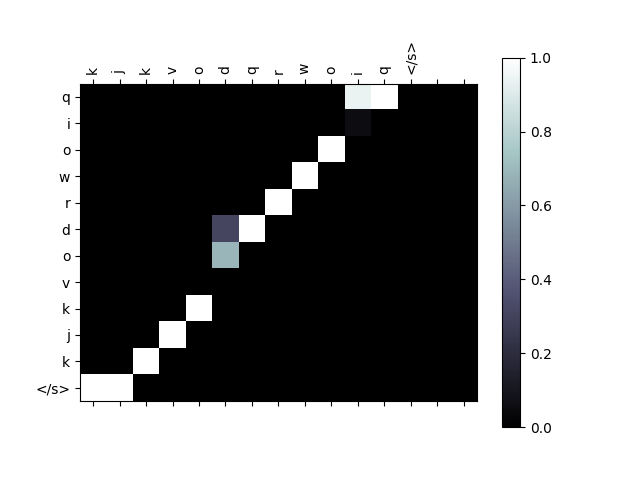

/data_hdd/git/speech_recognition/env_stt/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/data_hdd/git/speech_recognition/env_stt/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


In [54]:
evaluateAndShowAttention()
#evaluateAndShowAttention("elle est trop petit .")
#evaluateAndShowAttention("je ne crains pas de mourir .")
#evaluateAndShowAttention("c est un jeune directeur plein de talent .")

In [103]:
generate_random_alphabet_index()

([6, 28, 8, 16, 5, 4, 16, 22, 14, 19, 6], 11)

In [168]:
for d in train_dataloader:
    inputs, targets, lengths = d
    print(inputs)
    print(targets)
    print(lengths)
    print(inputs.shape, targets.shape, lengths.shape)
    break

tensor([[ 6, 24, 18, 24,  6, 16, 20, 27, 20, 18, 24, 19,  1,  2,  2],
        [25, 14, 18, 19, 23,  7, 13, 28,  3, 24, 25, 21,  1,  2,  2],
        [ 4,  7, 25, 18, 16, 17, 27, 27, 21, 10,  6, 19,  1,  2,  2],
        [12,  9, 12, 16,  7, 20, 18, 19, 14, 18, 24,  1,  2,  2,  2],
        [18, 16, 19, 14,  4, 18,  8,  4,  7, 10,  7,  1,  2,  2,  2],
        [20,  7, 20, 20,  5,  7, 21, 20, 14, 10, 25,  1,  2,  2,  2],
        [18, 25, 20,  7,  6, 24, 25, 22, 20, 14, 10,  1,  2,  2,  2],
        [27,  3, 28, 28,  4, 18, 26, 28, 22, 21, 16,  1,  2,  2,  2],
        [16, 25, 27, 15, 20, 25, 11, 10, 13, 14, 16,  1,  2,  2,  2],
        [16, 14, 13,  3,  3, 20,  9, 14, 16,  3,  1,  2,  2,  2,  2],
        [20, 26, 27, 23, 26, 15, 19, 24,  8, 23,  1,  2,  2,  2,  2],
        [13, 27, 19, 21, 12, 11,  4, 11,  8, 21,  1,  2,  2,  2,  2],
        [ 6, 28,  3, 27,  4, 14, 11, 23,  5, 22,  1,  2,  2,  2,  2],
        [17, 16,  5,  8,  6, 12, 28, 17, 27, 14,  1,  2,  2,  2,  2],
        [22, 26, 20,

In [86]:
attn_weight

tensor([[5.4647e-19, 2.1158e-09, 1.8052e-20, 3.0840e-15, 3.7146e-18, 6.9406e-07,
         1.4109e-14, 1.0539e-04, 3.1010e-19, 4.9029e-15, 3.6380e-24, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.9686e-15, 1.3957e-07, 1.1322e-20, 1.9118e-13, 2.1563e-17, 4.8231e-06,
         1.6138e-14, 9.8179e-05, 2.9850e-18, 9.9988e-01, 4.0312e-21, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.5487e-17, 1.4903e-03, 2.0948e-25, 9.1275e-15, 2.0745e-17, 7.3675e-03,
         1.1504e-14, 9.9980e-01, 9.9999e-01, 1.1863e-04, 1.4920e-18, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.7854e-13, 2.0262e-01, 2.3705e-18, 1.4770e-09, 1.5182e-15, 6.6326e-01,
         6.8544e-14, 7.7468e-16, 1.3229e-05, 3.9783e-09, 5.8446e-16, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.5851e-14, 1.0260e-03, 1.1164e-19, 7.2985e-13, 1.6837e-18, 3.2937e-01,
         1.0000e+00, 3.8924e-16, 5.2032e-14, 5.3614e-10, 3.1419e-12, 0.0000e+00,
      